In [1]:
import numpy as np
import pandas as pd 

In [2]:
# creating nodes
columns = ['coordinate','displacement','slope','load','moment']
data = [[0,0,0,np.nan,np.nan],
        [120,np.nan,0,-10000,0],
        [240,0,0,np.nan,np.nan],
        [360,np.nan,0,-10000,0],
        [480,0,0,np.nan,np.nan]]
nodes = pd.DataFrame(data,columns=columns)
nodes

,coordinate,displacement,slope,load,moment
0,0,0.0,0,NaN,NaN
1,120,NaN,0,-10000.0,0.0
2,240,0.0,0,NaN,NaN
3,360,NaN,0,-10000.0,0.0
4,480,0.0,0,NaN,NaN


In [3]:
# creating elements
columns = ['start','end','length','material','MoI']
data = [[0,1,120,30e6,500],
        [1,2,120,30e6,500],
        [2,3,120,30e6,500],
        [3,4,120,30e6,500]]
elements = pd.DataFrame(data,columns=columns)
elements

,start,end,length,material,MoI
0,0,1,120,30000000.0,500
1,1,2,120,30000000.0,500
2,2,3,120,30000000.0,500
3,3,4,120,30000000.0,500


In [4]:
def compute_localK(element):
    L = element['length']
    c = element['material']*element['MoI']/(L**3)
    k = np.array([[12, 6*L, -12, 6*L],
                [6*L, 4*L*L, -6*L, 2*L*L],
                [-12, -6*L, 12, -6*L],
                [6*L, 2*L*L, -6*L, 4*L*L]])*c
    return k.round(3)
elements['k'] = elements.apply(compute_localK,axis=1)
elements

,start,end,length,material,MoI,k
0,0,1,120,30000000.0,500,"[[104166.667, 6250000.0, -104166.667, 6250000...."
1,1,2,120,30000000.0,500,"[[104166.667, 6250000.0, -104166.667, 6250000...."
2,2,3,120,30000000.0,500,"[[104166.667, 6250000.0, -104166.667, 6250000...."
3,3,4,120,30000000.0,500,"[[104166.667, 6250000.0, -104166.667, 6250000...."


In [5]:
def compute_globalK(element):
    N = len(nodes)
    indices = np.arange(N*2)
    indices = indices.reshape(-1,2)

    K = np.zeros([N*2,N*2])

    start = element['start']
    end = element['end']
    indices = np.hstack([indices[start],indices[end]])
    K[np.ix_(indices,indices)] = element['k']

    return K
K = elements.apply(compute_globalK,axis=1).sum()
K  


array([[ 1.04166667e+05,  6.25000000e+06, -1.04166667e+05,
         6.25000000e+06,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 6.25000000e+06,  5.00000000e+08, -6.25000000e+06,
         2.50000000e+08,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-1.04166667e+05, -6.25000000e+06,  2.08333334e+05,
         0.00000000e+00, -1.04166667e+05,  6.25000000e+06,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 6.25000000e+06,  2.50000000e+08,  0.00000000e+00,
         1.00000000e+09, -6.25000000e+06,  2.50000000e+08,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -1.04166667e+05,
        -6.25000000e+06,  2.08333334e+05,  0.00000000e+00,
        -1.04166667e+05,  6.25000000e+06,  0.00000000e+00,
         0.

In [6]:
def partition_k(K, A, B):
    KAA = K[np.ix_(A,A)]
    KAB = K[np.ix_(A,B)]
    KBA = K[np.ix_(B,A)]
    KBB = K[np.ix_(B,B)]
    return KAA, KAB, KBA, KBB

U = nodes[['displacement','slope']].to_numpy()
U = U.ravel()
A = np.isnan(U)

P = nodes[['load','moment']].to_numpy()
P = P.ravel()
B = np.isnan(P)

KAA, KAB, KBA, KBB = partition_k(K,A,B)

In [7]:
# known displacements, UB
UB = U[B]
# known loads, PA
PA = P[A]

UA = np.dot(np.linalg.inv(KAA),(PA - np.dot(KAB,UB)))
U[A] = UA

PB = np.dot(KBA,UA) + np.dot(KBB,UB)
P[B] = PB

In [8]:
results = nodes.copy()
results[['displacement','slope']] = U.reshape(-1,2)
results[['load','moment']] = P.reshape(-1,2)
results.round(3)

,coordinate,displacement,slope,load,moment
0,0,0.000,0.0,5000.0,299999.999
1,120,-0.048,0.0,-10000.0,0.000
2,240,0.000,0.0,10000.0,0.000
3,360,-0.048,0.0,-10000.0,0.000
4,480,0.000,0.0,5000.0,-299999.999


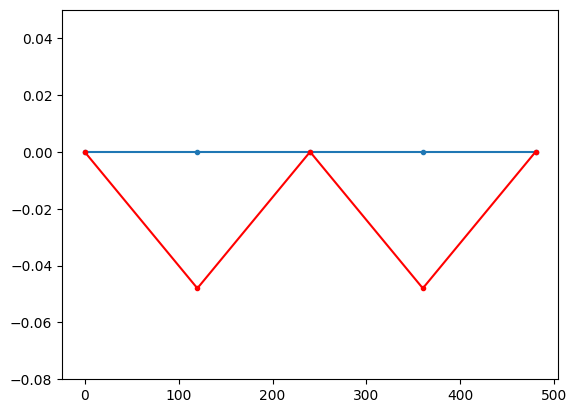

In [20]:
import matplotlib.pyplot as plt
N = len(nodes)
y = np.zeros([N])
plt.plot(results['coordinate'],y,'.-')

plt.plot(results['coordinate'],results['displacement'],'r.-')
plt.ylim([-0.08,0.05])
plt.show()

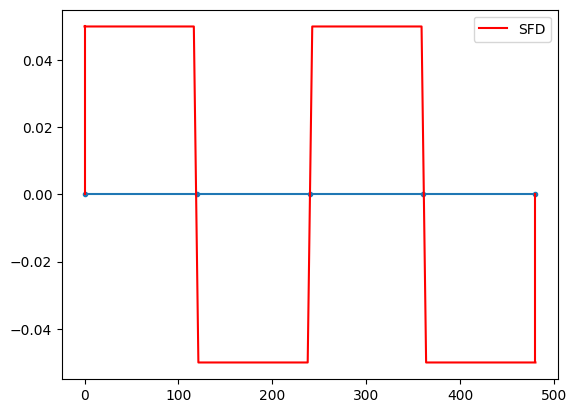

In [12]:
plt.plot(results['coordinate'],y,'.-')
def SFD():
    x = np.linspace(0,480,100)
    X = []
    V = []
    for i in x:
        v = (results.loc[0,'load'] + results.loc[1,'load']*(i>results.loc[1,'coordinate']) + results.loc[2,'load']*(i>results.loc[2,'coordinate']) + results.loc[3,'load']*(i>results.loc[3,'coordinate']))/10e4
        V.append(v)
        X.append(i)
    plt.plot(X,V,'r',label='SFD')
    plt.plot([results.loc[0,'coordinate'],results.loc[0,'coordinate']], [y[0],results.loc[0,'load']/10e4],'r')
    plt.plot([results.loc[4,'coordinate'],results.loc[4,'coordinate']], [y[4],-V[N]],'r')
SFD()
plt.legend()
plt.show()


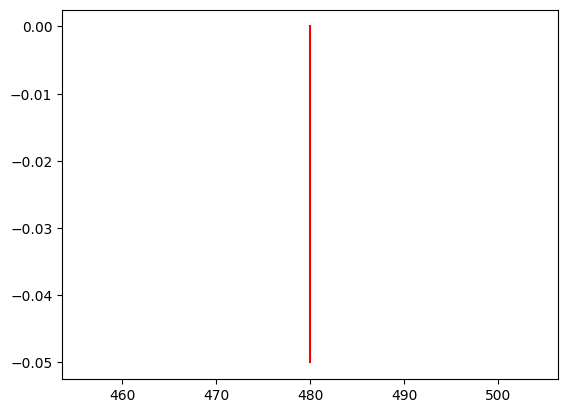

In [ ]:
plt.plot([480,480], [0,-0.05],'r')

In [ ]:
x = 53.33
V  = results.loc[0,'load'] + results.loc[1,'load']*(x>results.loc[1,'coordinate']) + results.loc[2,'load']*(x>results.loc[2,'coordinate']) + results.loc[3,'load']*(x>results.loc[3,'coordinate'])
V

5000.0